In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, zero_one_loss, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from matplotlib import pyplot
from imblearn.under_sampling import NearMiss
from collections import Counter

In [2]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional\bank-additional.csv', sep = ';', engine= 'python')   

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
print(df.shape)

(4119, 20)


In [3]:
#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_encoded = pd.get_dummies(df['job'], prefix='job', drop_first=True)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['job']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

df.insert(0, 'ID', range(0, len(df)))
features = pd.merge(df_encoded, df, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

In [4]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)

In [5]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(train_features)
X_test_ss = ss.transform(test_features)

In [6]:
estimators = [10, 50, 100, 200, 500] 
max_depths = [3, 6, 10, 15, 20] 

grid_values = {'n_estimators': estimators, 'max_depth':max_depths}

clf = GridSearchCV(RandomForestClassifier(), grid_values, scoring='roc_auc', n_jobs=-1, verbose=10, cv=10, return_train_score=True)
clf.fit(X_train_ss, train_targets)
best_n_estimators_value = clf.best_params_['n_estimators']
best_max_depth_value = clf.best_params_['max_depth']
best_score = clf.best_score_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


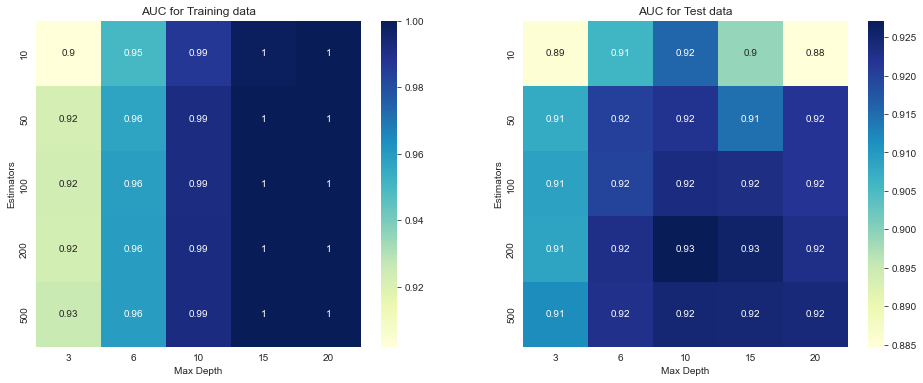

In [7]:
max_depth_list = list(clf.cv_results_['param_max_depth'].data)
estimators_list = list(clf.cv_results_['param_n_estimators'].data)

sns.set_style("whitegrid")
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
data = pd.DataFrame(data={'Estimators':estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_train_score']})
data = data.pivot(index='Estimators', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Training data')
plt.subplot(1,2,2)
data = pd.DataFrame(data={'Estimators':estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_test_score']})
data = data.pivot(index='Estimators', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Test data')
plt.show()

In [8]:
def plot_roc_curve(roc_auc_train, roc_auc_test):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_tr, tpr_tr, 'g', label = 'Training AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_ts, tpr_ts, 'b', label = 'Testing AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

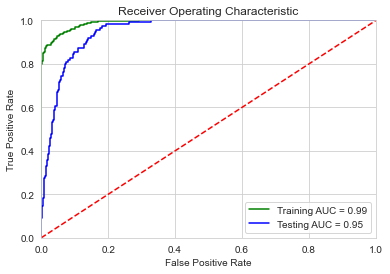

In [9]:
#Best hyper parameter 
clf = RandomForestClassifier(n_estimators=best_n_estimators_value, max_depth=best_max_depth_value)
clf.fit(X_train_ss, train_targets)

y_pred_train = clf.predict_proba(X_train_ss)[:,1]
y_pred_test = clf.predict_proba(X_test_ss)[:,1]

   
#train data ROC
fpr_tr, tpr_tr, threshold = roc_curve(train_targets, y_pred_train)
roc_auc_train = auc(fpr_tr, tpr_tr)

#test data ROC
fpr_ts, tpr_ts, threshold = roc_curve(test_targets, y_pred_test)
roc_auc_test = auc(fpr_ts, tpr_ts)

#Plot ROC curve
plot_roc_curve(roc_auc_train, roc_auc_test)

In [10]:
acc_rf_grid = accuracy_score(test_targets, clf.predict(X_test_ss))

print(acc_rf_grid)

0.8944174757281553


In [11]:
# Compare both the models using Prettytable library    
x = PrettyTable()

x.field_names = ["Model", "n_estimators", "max_depth","Accuracy"]

x.add_row(["Random Forest with GridSearch", best_n_estimators_value, best_max_depth_value, acc_rf_grid])

print(x)

+-------------------------------+--------------+-----------+--------------------+
|             Model             | n_estimators | max_depth |      Accuracy      |
+-------------------------------+--------------+-----------+--------------------+
| Random Forest with GridSearch |     200      |     10    | 0.8944174757281553 |
+-------------------------------+--------------+-----------+--------------------+
